# TurbineClusterModelChain example

This example shows you how to calculate the power output of wind farms and wind turbine clusters using the windpowerlib. A cluster can be useful if you want to calculate the feed-in of a region for which you want to use one single weather data point.

Functions that are used in the ModelChain example, like the initialization of wind turbines, are imported and used without further explanation.

### Imports and initialization of wind turbines

The import of weather data and the initialization of wind turbines is done as in the ``modelchain_example``. Be aware that currently for wind farm and wind cluster calculations wind turbines need to have a power curve as some calculations do not work with the power coefficient curve.

In [1]:
__copyright__ = "Copyright oemof developer group"
__license__ = "GPLv3"

import modelchain_example as mc_e
from windpowerlib import TurbineClusterModelChain, WindTurbineCluster, WindFarm

import logging
logging.getLogger().setLevel(logging.DEBUG)

In [2]:
# Get weather data
weather = mc_e.get_weather_data('weather.csv')
print(weather[['wind_speed', 'temperature', 'pressure']][0:3])

# Initialize wind turbines
my_turbine, e126, dummy_turbine = mc_e.initialize_wind_turbines()
print()
print('nominal power of my_turbine: {}'.format(my_turbine.nominal_power))

                          wind_speed          temperature         pressure
                                  10       80          2       10       0 
2010-01-01 00:00:00+01:00    5.32697  7.80697      267.60  267.57  98405.7
2010-01-01 01:00:00+01:00    5.46199  7.86199      267.60  267.55  98382.7
2010-01-01 02:00:00+01:00    5.67899  8.59899      267.61  267.54  98362.9

nominal power of my_turbine: 3000000.0


/home/sabine/virtualenvs/windpowerlib/windpowerlib/windpowerlib/wind_turbine.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  wpp_df.dropna(axis=1, inplace=True)


### Initialize wind farm

To initialize a specific wind farm you need to provide a wind turbine fleet and optionally a wind farm efficiency and a name as an identifier.

In [3]:
# specification of wind farm
example_farm_data = {
    'name': 'example_farm',
    'wind_turbine_fleet': [{'wind_turbine': my_turbine,
                            'number_of_turbines': 6},
                           {'wind_turbine': e126,
                            'number_of_turbines': 3}
                           ]}

# initialize WindFarm object
example_farm = WindFarm(**example_farm_data)

Following, a wind farm with a constant efficiency is defined. A wind farm efficiency can also be dependent on the wind speed in which case it needs to be provided as a dataframe with 'wind_speed' and 'efficiency' columns containing wind speeds in m/s and the corresponding dimensionless wind farm efficiency.

In [4]:
# specification of wind farm (2) with a wind farm efficiency
example_farm_2_data = {
    'name': 'example_farm_2',
    'wind_turbine_fleet': [{'wind_turbine': my_turbine,
                            'number_of_turbines': 6},
                           {'wind_turbine': e126,
                            'number_of_turbines': 3}],
    'efficiency': 0.9}

# initialize WindFarm object
example_farm_2 = WindFarm(**example_farm_2_data)

print('nominal power of first turbine type of example_farm_2: {}'.format(
    example_farm_2.wind_turbine_fleet[0]['wind_turbine'].nominal_power))

nominal power of first turbine type of example_farm_2: 3000000.0


### Initialize wind turbine cluster

Like for a wind farm for the initialization of a wind turbine cluster you can use a dictionary that contains the basic parameters. A wind turbine cluster is defined by its wind farms.

In [5]:
# specification of cluster data
example_cluster_data = {
    'name': 'example_cluster',
    'wind_farms': [example_farm, example_farm_2]}

# initialize WindTurbineCluster object
example_cluster = WindTurbineCluster(**example_cluster_data)


### Use the TurbineClusterModelChain to calculate power output

The TurbineClusterModelChain is a class that provides all necessary steps to calculate the power output of a wind farm or wind turbine cluster. 

Like the ModelChain (see [basic example](modelchain_example.ipynb)) you can use the TurbineClusterModelChain with default parameters as shown in this example for the wind farm or specify custom parameters as done here for the cluster.
If you use the 'run_model' method first the aggregated power curve and the mean hub height of the wind farm/cluster is calculated, then inherited functions of the ModelChain are used to calculate the wind speed and density (if necessary) at hub height. After that, depending on the parameters, wake losses are applied and at last the power output is calculated.

In [6]:
# power output calculation for example_farm
# initialize TurbineClusterModelChain with default parameters and use
# run_model method to calculate power output
mc_example_farm = TurbineClusterModelChain(example_farm).run_model(weather)
# write power output time series to WindFarm object
example_farm.power_output = mc_example_farm.power_output 

DEBUG:root:Wake losses considered by dena_mean wind efficiency curve.
DEBUG:root:Aggregated power curve not smoothed.
DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating power output using power curve.


In [7]:
# set efficiency of example_farm to apply wake losses
example_farm.efficiency = 0.9

# power output calculation for turbine_cluster
# own specifications for TurbineClusterModelChain setup
modelchain_data = {
        'wake_losses_model': 'wind_farm_efficiency',  #
                                           # 'dena_mean' (default), None,
                                           # 'wind_farm_efficiency' or name
                                           #  of another wind efficiency curve
                #  see :py:func:`~.wake_losses.get_wind_efficiency_curve`
        'smoothing': True,  # False (default) or True
        'block_width': 0.5,  # default: 0.5
        'standard_deviation_method': 'Staffell_Pfenninger',  #
                                            # 'turbulence_intensity' (default)
                                            # or 'Staffell_Pfenninger'
        'smoothing_order': 'wind_farm_power_curves',  #
                                        # 'wind_farm_power_curves' (default) or
                                        # 'turbine_power_curves'
        'wind_speed_model': 'logarithmic',  # 'logarithmic' (default),
                                            # 'hellman' or
                                            # 'interpolation_extrapolation'
        'density_model': 'ideal_gas',  # 'barometric' (default), 'ideal_gas' or
                                       # 'interpolation_extrapolation'
        'temperature_model': 'linear_gradient',  # 'linear_gradient' (def.) or
                                                 # 'interpolation_extrapolation'
        'power_output_model': 'power_curve',  # 'power_curve' (default) or
                                              # 'power_coefficient_curve'
        'density_correction': True,  # False (default) or True
        'obstacle_height': 0,  # default: 0
        'hellman_exp': None}  # None (default) or None

# initialize TurbineClusterModelChain with own specifications and use
# run_model method to calculate power output
mc_example_cluster = TurbineClusterModelChain(
        example_cluster, **modelchain_data).run_model(weather)
# write power output time series to WindTurbineCluster object
example_cluster.power_output = mc_example_cluster.power_output

DEBUG:root:Wake losses considered with wind_farm_efficiency.
DEBUG:root:Aggregated power curve smoothed by method: Staffell_Pfenninger
DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating temperature using temperature gradient.
DEBUG:root:Calculating density using ideal gas equation.
DEBUG:root:Calculating power output using power curve.


### Plot results

If you have matplotlib installed you can visualize the calculated power output.

In [8]:
# try to import matplotlib
logging.getLogger().setLevel(logging.WARNING)
try:
    from matplotlib import pyplot as plt
    # matplotlib inline needed in notebook to plot inline
    %matplotlib inline 
except ImportError:
    plt = None

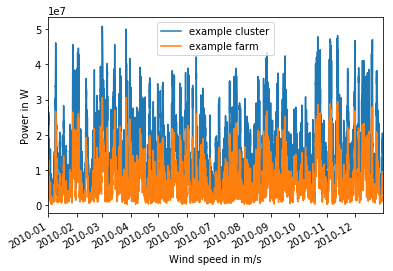

In [9]:
# plot turbine power output
if plt:
    example_cluster.power_output.plot(legend=True, label='example cluster')
    example_farm.power_output.plot(legend=True, label='example farm')
    plt.xlabel('Wind speed in m/s')
    plt.ylabel('Power in W')
    plt.show()